## Mounting Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
WORKING_DIR = "/content/drive/MyDrive/asiCD-dev"

%cd drive/MyDrive/asiCD-dev

/content/drive/MyDrive/asiCD-dev


In [5]:

!rm -rf ../tmp/

In [6]:
%ls -a

20190715120000_11.jpg  20190721160020_11.jpg  .png
20190715130000_11.jpg  20190722150020_11.jpg  predictions/
20190715140000_11.jpg  config.json            scripts/
20190716100020_11.jpg  dataset/               some_weights.h5
20190716120020_11.jpg  .ipynb_checkpoints/    train-model.ipynb
20190717160020_11.jpg  output/


## Installing Dependencies

In [7]:
# !pip install tensorflow-gpu==2.1.0
# !pip install tqdm
# !pip install imgaug

In [8]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

import random
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image

from tqdm import tqdm_notebook

%matplotlib inline
print(tf.__version__)

run_flag = 0

2.4.0


In [9]:
from scripts import utilities
from scripts.models import model_vgg16
from scripts.models import model_resnet18
from scripts.models import model_densenet21

In [10]:
config = utilities.read_json("config.json")
print(config)

dataset_path = config["dataset_path"]
AUG_CONFIG = config["aug_config"]

{'dataset_path': 'dataset/swimseg-2', 'model': {}, 'aug_config': {'target_size': [128, 128]}}


In [11]:
print(dataset_path)

dataset/swimseg-2


##  Preprocessing Data
- Required file structure (for ImageDataGenerator)
```
dataset
├───test
│   └───img
├───test_labels
│   └───img
├───train
│   └───img
├───train_labels
│   └───img
├───val
│   └───img
├───val_lables
│   └───img
```
- Ops:
  1. Downsamling
  2. Gaussian Filter (Pending)
  3. Undistorting (Pending)
- Saving processed Images and Masks

### Output File Structure

In [12]:
%ls

20190715120000_11.jpg  20190716120020_11.jpg  config.json   scripts/
20190715130000_11.jpg  20190717160020_11.jpg  dataset/      some_weights.h5
20190715140000_11.jpg  20190721160020_11.jpg  output/       train-model.ipynb
20190716100020_11.jpg  20190722150020_11.jpg  predictions/


In [13]:
# Creating output file structure
utilities.create_output_dir()
dataset_path = utilities.create_dataset_dir("output")
run_flag += 1
print(dataset_path)

output folder exists
output/2021-01-10-19-38


### Preprocessing

## Loading Images and Labels from Google Drive

In [14]:
dataset_path = "dataset/swimseg-2-modded"

In [15]:
train_generator = utilities.get_img_mask_generators(dataset_path + "/train", aug_config = AUG_CONFIG)
test_generator = utilities.get_img_mask_generators(dataset_path + "/test", aug_config = AUG_CONFIG)
val_generator = utilities.get_img_mask_generators(dataset_path + "/val", aug_config = AUG_CONFIG)

From dataset/swimseg-2-modded/train
Found 861 images belonging to 1 classes.
Found 861 images belonging to 1 classes.
From dataset/swimseg-2-modded/test
Found 51 images belonging to 1 classes.
Found 51 images belonging to 1 classes.
From dataset/swimseg-2-modded/val
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


In [16]:
""" TEST """
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

image_generator = image_datagen.flow_from_directory(dataset_path + "/train",
                                                    target_size= (128,128),
                                                    color_mode="rgb",
                                                    class_mode=None,
                                                    seed=0)
mask_generator = mask_datagen.flow_from_directory(dataset_path + "/train_labels",
                                                  target_size= (128,128),
                                                  color_mode="grayscale",
                                                  class_mode=None,
                                                  seed=0)


Found 861 images belonging to 1 classes.
Found 861 images belonging to 1 classes.


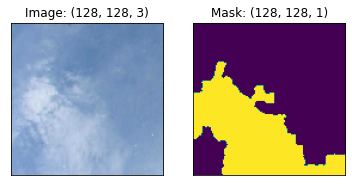

' END '

In [17]:
img_arr = image_generator.next()
mask_arr = mask_generator.next()
for i in range(0,1):
    image = img_arr[i]
    mask = mask_arr[i]
    
    plt.subplot(1,2,1)
    plt.title(f"Image: {image.shape}")
    plt.imshow(image / 255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1,2,2)
    plt.title(f"Mask: {mask.shape}")
    plt.imshow(mask[:,:,0] / 255)
    plt.xticks([])
    plt.yticks([])

    plt.show()

""" END """

In [18]:
# TRAIN_IMAGES_PATH = "/content/drive/My Drive/asiCD/swimseg-dataset-npy/2020-11-14-12-21-train_images.npy"
# TRAIN_LABELS_PATH = "/content/drive/My Drive/asiCD/swimseg-dataset-npy/2020-11-14-12-21-train_labels.npy"

# train_images = load_npy(TRAIN_IMAGES_PATH)
# train_labels = load_npy(TRAIN_LABELS_PATH)

# TEST_IMAGES_PATH = "/content/drive/My Drive/asiCD/swimseg-dataset-npy/2020-11-14-12-21-test_images.npy"
# TEST_LABELS_PATH = "/content/drive/My Drive/asiCD/swimseg-dataset-npy/2020-11-14-12-21-test_labels.npy"

# test_images = load_npy(TEST_IMAGES_PATH)
# test_labels = load_npy(TEST_LABELS_PATH)

# VAL_IMAGES_PATH = "/content/drive/My Drive/asiCD/swimseg-dataset-npy/2020-11-14-12-21-val_images.npy"
# VAL_LABELS_PATH = "/content/drive/My Drive/asiCD/swimseg-dataset-npy/2020-11-14-12-21-val_labels.npy"

# val_images = load_npy(VAL_IMAGES_PATH)
# val_labels = load_npy(VAL_LABELS_PATH)

In [19]:
models = [model_vgg16, model_resnet18, model_densenet21]

In [20]:
model = models[1].MultiExpoNet.build(128, 128, 1, 1, 3, 0.001, 10)

stack 1
stack 2
stack 3
stack 4
stack 5
stack 6


In [21]:
model.summary()

Model: "cnn_model_1_exp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 128, 8)  1176        input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 128, 128, 8)  32          conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 8)  0           norm_1[0][0]                     
____________________________________________________________________________________

In [22]:
EPOCHS = 10
BS = 32

train_num = 861
test_num = 51

steps_per_epoch = train_num // BS
validation_steps = test_num // BS

In [23]:
hist = model.fit(test_generator, 
                 epochs= EPOCHS,
                 steps_per_epoch= steps_per_epoch, 
                 validation_data= val_generator,
                 validation_steps= validation_steps)

# hist = model.fit(x= img_arr, y =mask_arr, epochs=10)

Epoch 1/10
26/26 [==============================] - 88s 3s/step - loss: 0.0000e+00 - accuracy: 0.3151 - val_loss: 0.0000e+00 - val_accuracy: 0.3710
Epoch 2/10
26/26 [==============================] - 44s 2s/step - loss: 0.0000e+00 - accuracy: 0.3157 - val_loss: 0.0000e+00 - val_accuracy: 0.4833
Epoch 3/10
26/26 [==============================] - 12s 479ms/step - loss: 0.0000e+00 - accuracy: 0.3158 - val_loss: 0.0000e+00 - val_accuracy: 0.3786
Epoch 4/10
26/26 [==============================] - 12s 458ms/step - loss: 0.0000e+00 - accuracy: 0.3139 - val_loss: 0.0000e+00 - val_accuracy: 0.4601
Epoch 5/10
26/26 [==============================] - 12s 478ms/step - loss: 0.0000e+00 - accuracy: 0.3149 - val_loss: 0.0000e+00 - val_accuracy: 0.4165
Epoch 6/10
26/26 [==============================] - 12s 460ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - val_loss: 0.0000e+00 - val_accuracy: 0.4072
Epoch 7/10
26/26 [==============================] - 12s 475ms/step - loss: 0.0000e+00 - accuracy: 0.

In [24]:
img_arr.shape

(32, 128, 128, 3)

In [25]:
mask_arr.shape

(32, 128, 128, 1)

In [26]:
model.save("some_weights.h5")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


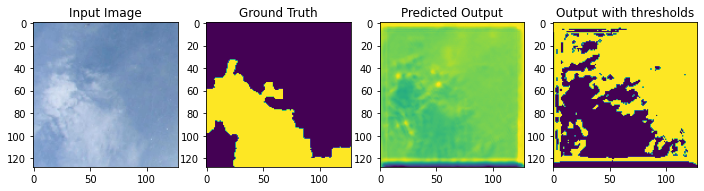

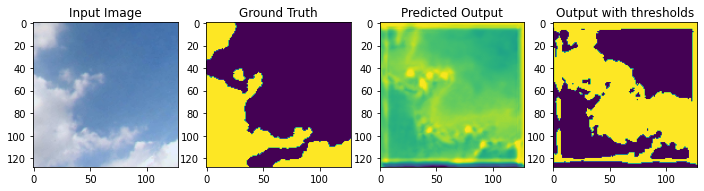

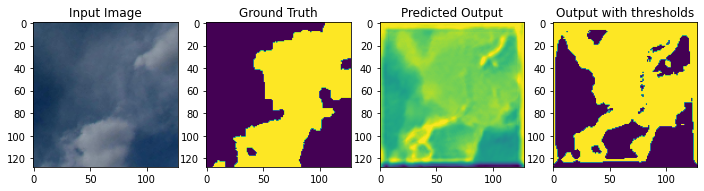

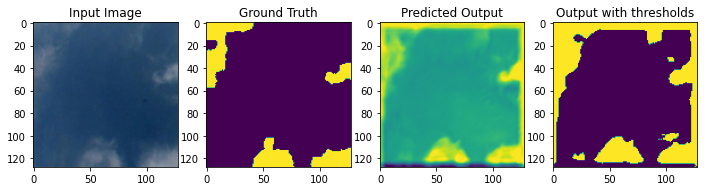

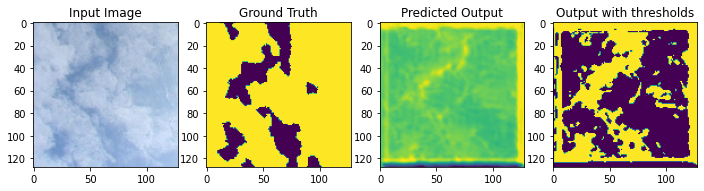

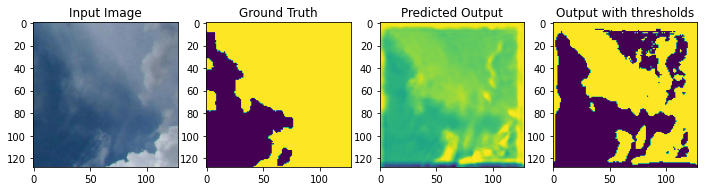

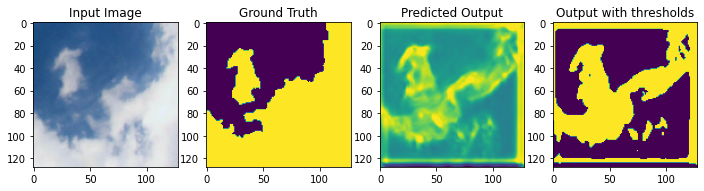

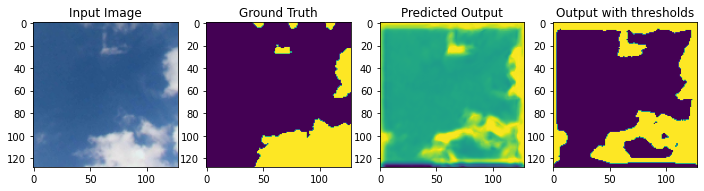

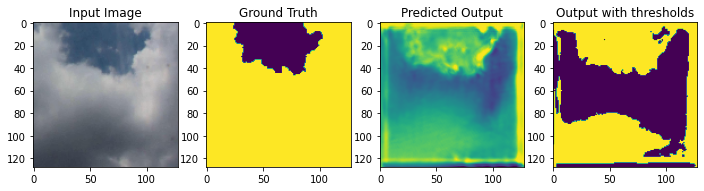

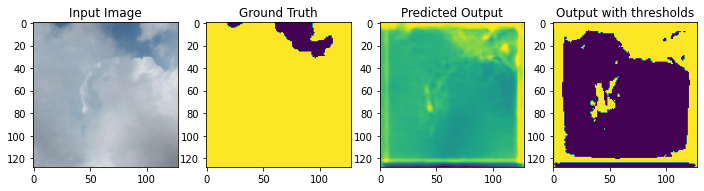

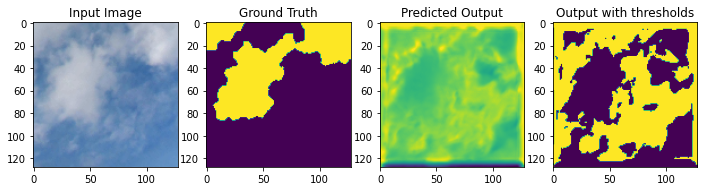

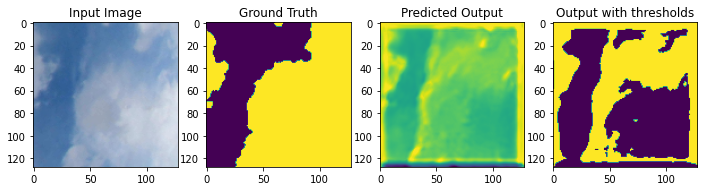

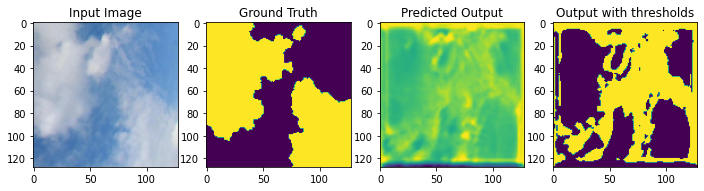

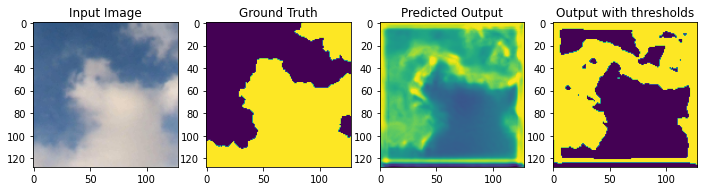

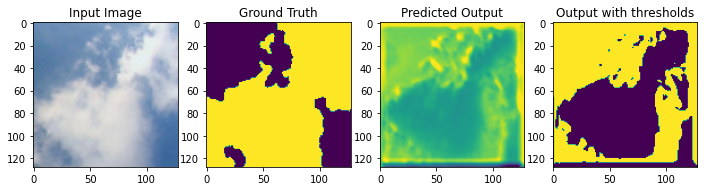

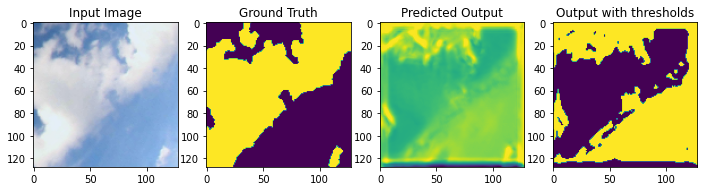

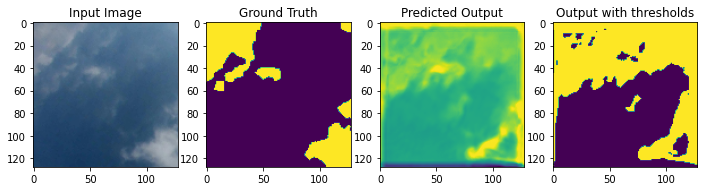

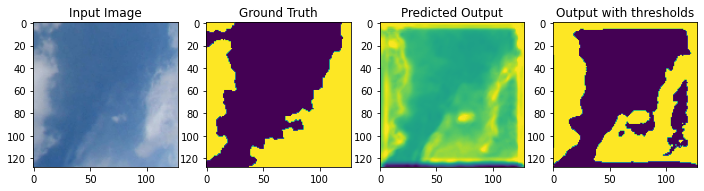

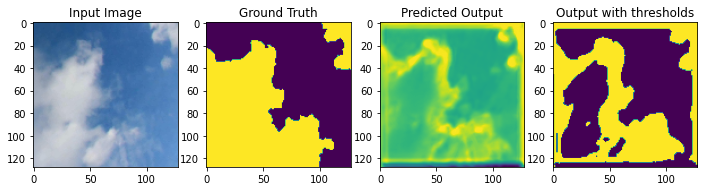

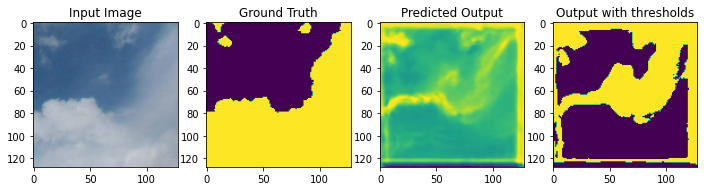

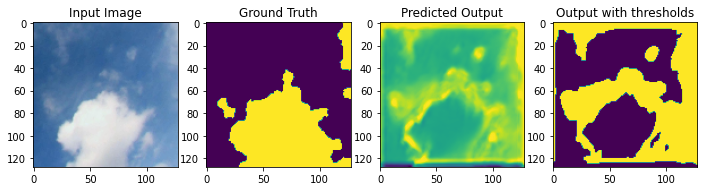

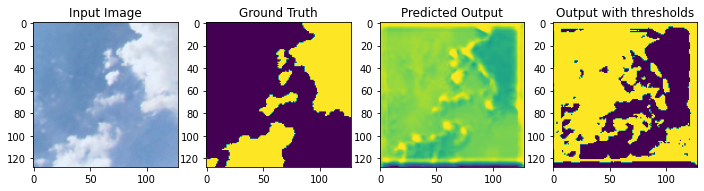

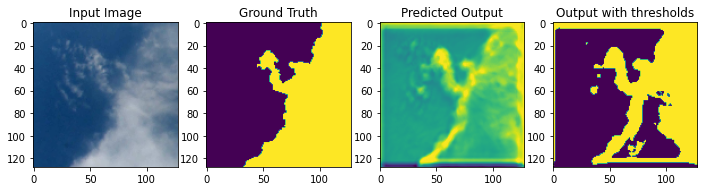

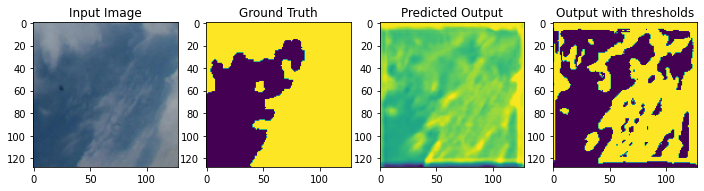

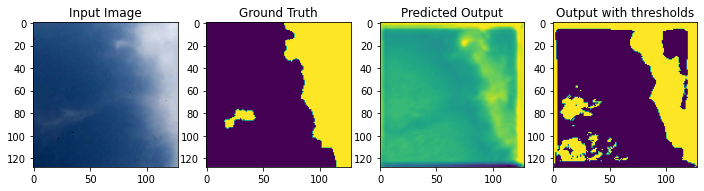

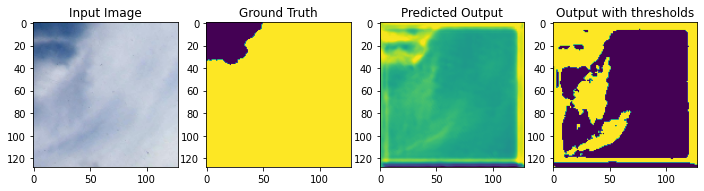

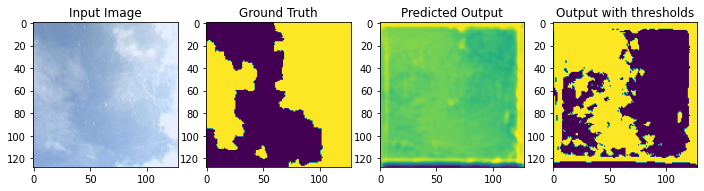

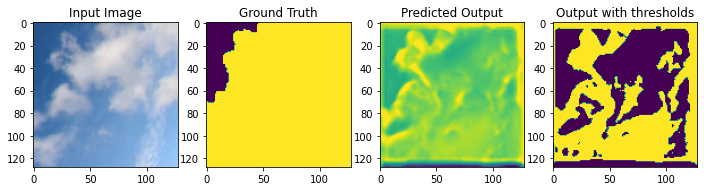

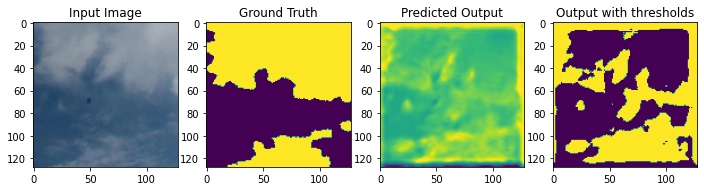

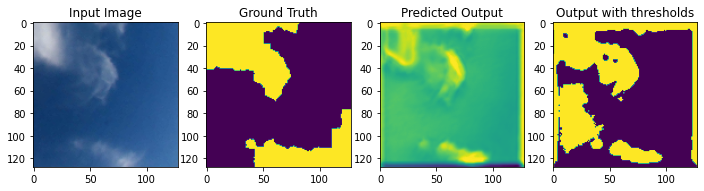

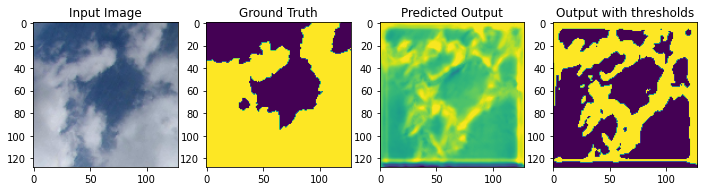

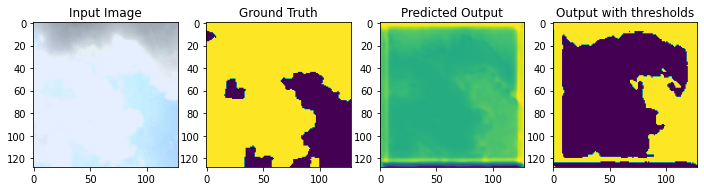

In [32]:
for sample_in in range(32):
  plt.figure(figsize=(15,15))
  y_pred = model.predict(np.expand_dims(img_arr[sample_in], axis=0))
  plt.subplot(1,5,1)
  plt.imshow(img_arr[sample_in,...]/255)
  plt.title('Input Image')
  plt.subplot(1,5,2)
  plt.imshow(mask_arr[sample_in,:,:,0])
  plt.title('Ground Truth')
  plt.subplot(1,5,3)
  y_pred += np.abs(np.min(y_pred))
  plt.imshow(y_pred[0,:,:,0] / np.max(y_pred))
  plt.title('Predicted Output')
  plt.subplot(1,5,4)
  y_pred = np.where(y_pred<np.average(y_pred),y_pred,255)
  y_pred = np.where(y_pred>np.average(y_pred),y_pred,0)
  plt.imshow(y_pred[0,:,:,0] / np.max(y_pred))
  plt.title('Output with thresholds')
  plt.savefig(f'./predictions/Image{sample_in}.png', dpi=400, bbox_inches ='tight' )
# plt.subplot(1,5,5)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(cax=cax,shrink=0.1) # need to work on positioning. orientation=horizontal is not helpful
plt.show() # plt.show() destorys the instance after display. Save fig before showing.

In [28]:
np.max(y_pred)

255.0

In [31]:
from tensorflow.keras.preprocessing.image import img_to_array
# List of output layer from the previously defined model
successive_outputs = [layer.output for layer in model.layers]

# Building a model with 1 input to multiple output structure
visualization_model = tf.keras.models.Model(
    inputs=model.input, outputs=successive_outputs
)

# preparing a random image from the training dataset
train_dir = '/content/drive/MyDrive/asiCD-dev/dataset/swimseg-2-modded/train/img'
train_files_list = os.listdir(train_dir)
img_path = random.choice([os.path.join(train_dir,f) for f in train_files_list])
img = load_img(
    img_path,
    target_size=(128, 128),
)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # (or) ==> x = x.reshape((1,)+x.shape) 
# print(x.shape)
x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]
# print(layer_names)
for layer_name,feature_map in zip(layer_names,successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]

        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[:,:,:,i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x,0,255).astype('uint8')
            display_grid[:, i* size : (i+1)*size] = x
    scale = 20./n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid('Off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

AttributeError: ignored

In [ ]:
# running inference on uploaded images

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for filename in uploaded.keys():

  path = './'+filename
  img = image.load_img(path,target_size=(128,128))
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  # print(x.shape)
  plt.gcf()
  plt.subplot(1,2,1)
  plt.imshow(x[0,...]/255.0)  
  plt.subplot(1,2,2)
  pred = model.predict(x)
  plt.imshow(pred[0,...],cmap='viridis')  
  plt.savefig('./predictions/pred.png',dpi=400)
  plt.show()